In [1]:
import networkx as nx
import cirq
import recirq
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from recirq.qaoa.problems import asymmetric_coupling_ferromagnet_chain,\
                                 asymmetric_coupling_ferromagnet_grid

In [4]:
n_qubits = 12
rs = np.random.RandomState(52)
graphs = []
ocs = [0.2, 0.5, 0.8, 1.0]
for oc in ocs:
    #graph = nx.random_regular_graph(3, n_qubits, seed=rs)
    #nx.set_edge_attributes(graph, values=1, name='weight')
    graph = asymmetric_coupling_ferromagnet_grid(n_qubits, rs=rs, other_coupling=oc, shuffle=False)
    #graph = asymmetric_coupling_ferromagnet_chain(n_qubits, rs=rs, other_coupling=oc, shuffle=False)
    graphs.append(graph)
del graph

for graph in graphs:
    nx.draw_networkx(graph)
    plt.show()

In [5]:
import scipy.optimize
from recirq.qaoa.classical_angle_optimization import optimize_instance_interp_heuristic, create_ZZ_HamC

In [6]:
hamc = create_ZZ_HamC(graphs[0], flag_z2_sym=False)
np.where(np.min(hamc) == hamc)[0]

array([   0, 4095])

In [7]:
from recirq.qaoa.continuous_extension import get_pzstars, get_answer_bitstrings, expectation

```python
# hyperparameters
npop = 50 # population size
sigma = 0.1 # noise standard deviation
alpha = 0.001 # learning rate

# start the optimization
solution = np.array([0.5, 0.1, -0.3])
w = np.random.randn(3) # our initial guess is random
for i in range(300):

  # print current fitness of the most likely parameter setting
  if i % 20 == 0:
    print('iter %d. w: %s, solution: %s, reward: %f' % 
          (i, str(w), str(solution), f(w)))

  # initialize memory for a population of w's, and their rewards
  N = np.random.randn(npop, 3) # samples from a normal distribution N(0,1)
  R = np.zeros(npop)
  for j in range(npop):
    w_try = w + sigma*N[j] # jitter w using gaussian of sigma 0.1
    R[j] = f(w_try) # evaluate the jittered version

  # standardize the rewards to have a gaussian distribution
  A = (R - np.mean(R)) / np.std(R)
  # perform the parameter update. The matrix multiply below
  # is just an efficient way to sum up all the rows of the noise matrix N,
  # where each row N[j] is weighted by A[j]
  w = w + alpha/(npop*sigma) * np.dot(N.T, A)
```

In [8]:
import itertools

In [9]:
def evolution_strategies(f, x0, npop=25, 
                         sigma_end=0.1, alpha_end=0.005,
                         sigma_beg=0.5, alpha_beg=0.01,
                         ramp_len=200,
                         rs=None, callback=None):
    if rs is None:
        rs = np.random
        
    w = x0.copy()
    dim = len(w)
    prev = np.inf
    
    sigmas = np.linspace(sigma_beg, sigma_end, ramp_len)
    alphas = np.linspace(alpha_beg, alpha_end, ramp_len)
    
    success = False
    for i, sigma, alpha in itertools.zip_longest(range(500), sigmas, alphas):
        if sigma is None:
            sigma = sigma_end
        if alpha is None:
            alpha = alpha_end
            
        if i % 10 == 0:
            curr = f(w)    
            print(f'{i:3d}  {curr:+.2f}  {sigma:.5f} {alpha:.5f} {prev-curr:+.2e}')
            if callback is not None:
                callback(w)
            if 1e-5 <= prev - curr < 1e-3:
                success = True
                break
            prev = curr
            
        
        N = rs.randn(npop, dim)
        R = np.zeros(npop)
        for j in range(npop):
            w_try = w + sigma*N[j]
            R[j] = -1.*f(w_try)
        A = (R - np.mean(R)) / np.std(R)
        w = w + alpha / (npop*sigma) * np.dot(N.T, A)

    print(i, success)
    return scipy.optimize.OptimizeResult(
        x=w,
        success=success,
        status=0,
        message='hi mom',
        fun=curr,
        nit=i,
    )   

In [10]:


def do_classical(classical_restart_i, x0, graph):
    evals = []
    pzstars = []

    def expectation_wrap(thetas):
        return expectation(graph, thetas)

    def callback(thetas):
        evals.append(expectation(graph, thetas))
        pzstars.append(get_pzstars(thetas, answer_bitstrings))

#     res = scipy.optimize.minimize(expectation_wrap, x0=x0, method='bfgs', callback=callback,
#                                  options={'disp': True})
    res = evolution_strategies(expectation_wrap, x0=x0, callback=callback)
    callback(res.x) 
    print(' ', classical_restart_i)
    return {
        'classical_restart_i': classical_restart_i,
        'res': res,
        'evals': evals,
        'pzstars': pzstars,
    }

In [11]:
def do_qaoa(graph, graph_i, sub_records):
    oresults = optimize_instance_interp_heuristic(graph=graph, p_max=10, 
                                                  verbose=True, param_guess_at_p1=[np.pi / 8, -np.pi / 8])
    return {
        'graph_i': graph_i,
        'oresults': oresults,
        'classical': sub_records,
    }

In [12]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=12, processes=True)
client = Client(cluster)

In [13]:
records = []
rs = np.random.RandomState(52)
for graph_i, graph in enumerate(graphs):
    sub_records = []
    answer_bitstrings = get_answer_bitstrings(graph)

    rets = []
    for classical_restart_i in range(50):
        rets.append(client.submit(do_classical, classical_restart_i, rs.uniform(size=n_qubits), graph))
        
    oresults = client.submit(optimize_instance_interp_heuristic, graph=graph, p_max=10, 
                             verbose=True, param_guess_at_p1=[np.pi / 8, -np.pi / 8])
    sub_records = [r.result() for r in rets]
    oresults = oresults.result()

    records += [{
        'graph_i': graph_i,
        'oresults': oresults,
        'classical': sub_records,
    }]

records = []
rs = np.random.RandomState(52)
for graph_i, graph in enumerate(graphs):
    sub_records = []
    answer_bitstrings = get_answer_bitstrings(graph)
    for classical_restart_i in range(10):
        evals = []
        pzstars = []
        def expectation_log(thetas):
            ret = expectation(graph, thetas)
            evals.append(ret)
            pzstars.append(get_pzstars(thetas, answer_bitstrings))
            print('.', end='', flush=True)
            return ret
        def expectation_wrap(thetas):
            return expectation(graph, thetas)
        
        def callback(thetas):
            evals.append(expectation(graph, thetas))
            pzstars.append(get_pzstars(thetas, answer_bitstrings))
            print('.', end='', flush=True)

        res = scipy.optimize.minimize(expectation_wrap, x0=rs.uniform(size=n_qubits), method='bfgs', callback=callback,
                                     options={'disp': True})
        callback(res.x)
        sub_records += [{
            'classical_restart_i': classical_restart_i,
            'res': res,
            'evals': evals,
            'pzstars': pzstars,
        }]
        print(' ', classical_restart_i)
    
    oresults = optimize_instance_interp_heuristic(graph=graph, p_max=10, 
                                                  verbose=True, param_guess_at_p1=[np.pi / 8, -np.pi / 8])
    records += [{
        'graph_i': graph_i,
        'oresults': oresults,
        'classical': sub_records,
    }]
        

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('colorblind')

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14, title_fontsize=16)

QBLUE = '#1967d2'
QRED = '#ea4335ff'
QGOLD = '#fbbc05ff'
QGREEN = '#34a853ff'
QGOLD2 = '#ffca28'
QBLUE2 = '#1e88e5'

In [15]:
record = records[-1]
for cr in record['classical']:
    print(cr['res'].fun, np.round(cr['res'].x, 2))

-8.951489968430158 [ 0.99  1.02  1.01  0.98  1.01  0.99  0.97  1.01  0.07 -0.02 -0.03  0.04]
-10.944804796475223 [-0.02  0.01  1.    1.01 -0.02  0.01  1.    1.01  0.02  0.02  0.99  1.05]
-16.96548792008594 [ 0.02  0.01 -0.03 -0.   -0.02 -0.02 -0.03  0.04  0.   -0.03  0.02 -0.01]
-16.947670112173668 [0.98 1.   0.98 1.01 0.99 1.   1.02 0.97 1.   0.99 1.   1.04]
-16.93428242331408 [0.99 1.01 1.01 1.01 0.97 1.01 1.   1.   0.99 1.   0.99 0.99]
-16.93186162488627 [0.99 1.02 1.02 1.01 1.03 0.99 1.   1.04 1.01 0.99 0.99 0.99]
-10.972914988346464 [-0.02 -0.03 -0.01  0.75  0.01  0.01  0.02  1.    0.01  0.01  0.01  0.89]
-10.954121505798447 [ 0.99  0.97  0.04 -0.02  1.01  1.02  0.01 -0.04  0.99  0.99 -0.01 -0.02]
-16.93184524310884 [1.   1.   1.03 1.   1.   0.97 1.01 0.98 1.05 1.02 1.02 1.02]
-16.968176897023397 [ 0.98 -1.    1.    1.    1.01  0.99  1.    0.98  0.97  1.01  0.99  1.  ]
-16.940973496481313 [1.03 1.02 0.96 0.99 0.99 0.98 1.   0.99 1.   1.02 1.   1.  ]
-16.895572523932948 [0.97 1.01 

{0: array([0, 0]), 1: array([0, 1]), 2: array([0, 2]), 3: array([0, 3]), 4: array([1, 0]), 5: array([1, 1]), 6: array([1, 2]), 7: array([1, 3]), 8: array([2, 0]), 9: array([2, 1]), 10: array([2, 2]), 11: array([2, 3])}


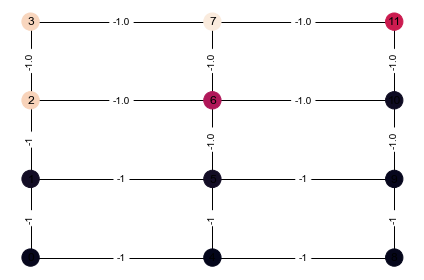

In [44]:
graph = graphs[-1]
colors = '0.99  1.02  1.01  0.98  1.01  0.99  0.97  1.01  0.07 -0.02 -0.03  0.04'
colors = '0.99  0.99  0.08  0.    1.    1.    0.38 -0.    0.99  0.99  1.01  0.72'
colors = '0.37  0.03 -0.01  0.01  1.01  0.63  0.    0.02  0.98  1.03  1.02  0.72'
colors = '-0.    0.03  0.97  0.98 -0.02  0.03  0.44  1.04 -0.01  0.    0.02  0.51'


colors = colors.split()
colors = [float(s) for s in colors]

pos = np.arange(graph.number_of_nodes())
pos = np.reshape(pos, (3,4))
pos = {i: np.squeeze(np.where(pos==i)) for i in range(graph.number_of_nodes())}
print(pos)
nx.draw_networkx(graph, pos=pos, node_color=colors)
nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels={(n1,n2): f'{w}' for n1, n2, w in graph.edges.data('weight')})
plt.axis('off')
plt.tight_layout()

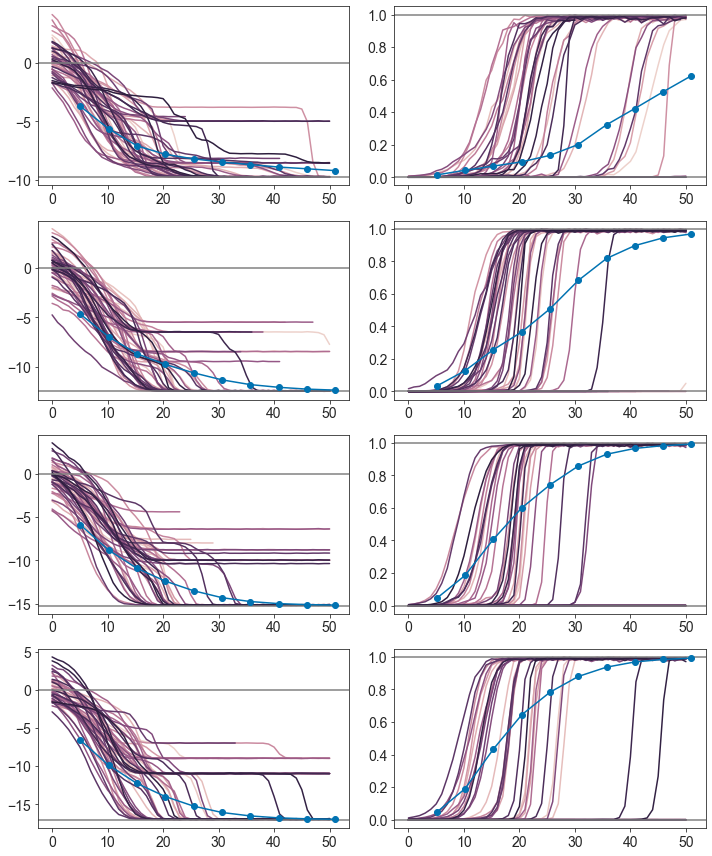

In [16]:
fig, axes = plt.subplots(len(records), 2, figsize=(2*5, len(records)*3), squeeze=False)
for (axl, axr), record in zip(axes, records):
    pal = sns.cubehelix_palette(n_colors=len(record['classical']))
    for cr,color in zip(record['classical'], pal):
        axl.plot(cr['evals'], color=color)
    
    xmax = max(len(c['evals']) for c in record['classical'])
    
    oresults = record['oresults']
    axl.axhline(oresults[0].min_c, color='grey')
    axl.axhline(0, color='grey')
    axl.plot(
        np.linspace(0,xmax,len(oresults)+1)[1:],
        [r.f_val for r in oresults],
        'o-',
    )    

    for cr,color in zip(record['classical'], pal):
        axr.plot(cr['pzstars'], color=color)
    axr.axhline(0, color='grey')
    axr.axhline(1, color='grey')
    axr.plot(
        np.linspace(0, xmax, len(oresults)+1)[1:],
        [r.pzstar for r in oresults],
        'o-',
    )

fig.tight_layout()

0.7268122146168784
0.7322996193357245
0.6137075097966087
0.6335802316936067


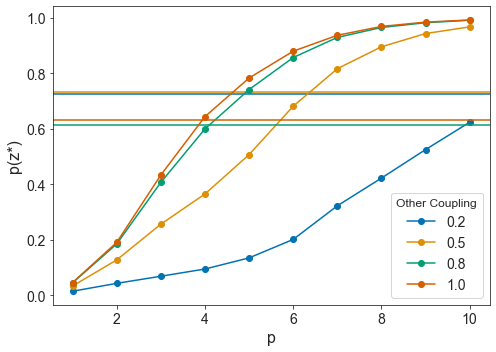

In [17]:
plt.subplots(figsize=(7,5))

effps = []
for record in records:
    ps = [cr['pzstars'][-1] for cr in record['classical']]
    meanp = np.mean(ps)
    
    qaoa_ps = [r.p for r in record['oresults']]
    qaoa_pzstars = [r.pzstar for r in record['oresults']]
    g, = plt.plot(qaoa_ps, qaoa_pzstars, 'o-', label=ocs[record['graph_i']])
    plt.axhline(meanp, color=g.get_color())
    print(meanp)
    
#     try:
#         effp = np.where(qaoa_pzstars > meanp)[0][0]
#         effp = qaoa_ps[effp]
#         plt.axvline(effp, color=g.get_color())
#     except IndexError:
#         effp = None
    #plt.ylim((0, 1))
    #plt.show()
    #effps.append(effp)
    
legend = plt.legend(loc='best', title='Other Coupling')
plt.setp(legend.get_title(), fontsize=12)    
plt.xlabel('p')
plt.ylabel('p(z*)')
plt.tight_layout()

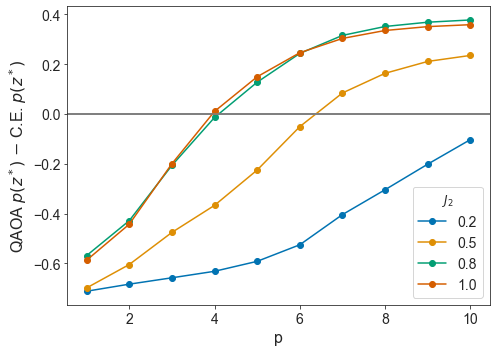

In [18]:
plt.subplots(figsize=(7,5))
for record in records:
    ps = [cr['pzstars'][-1] for cr in record['classical']]
    meanp = np.mean(ps)
    
    qaoa_ps = [r.p for r in record['oresults']]
    qaoa_pzstars = np.array([r.pzstar for r in record['oresults']])
    g, = plt.plot(qaoa_ps, qaoa_pzstars - meanp, 'o-', label=ocs[record['graph_i']])

    #effp = np.where(qaoa_pzstars > meanp)[0][0]
    #plt.plot([qaoa_ps[effp]], [qaoa_pzstars[effp]-meanp], '*', color=g.get_color(), ms=15)
    plt.axhline(0, color='grey')
    
legend = plt.legend(loc='best', title=r'$J_2$')
plt.setp(legend.get_title(), fontsize=12)

plt.xlabel('p')
plt.ylabel('QAOA $p(z^*)$ $-$ C.E. $p(z^*)$')
plt.tight_layout()

for record in records:
    pal = sns.cubehelix_palette(n_colors=len(record['classical']))        
    best_classical = min(cr['res'].fun for cr in record['classical'])
    oresults = record['oresults']
    min_c = oresults[0].min_c
    print(-1*(best_classical-min_c)/min_c)

    oresults = np.array([r.f_val for r in oresults])
    diff_c = -1*(oresults - best_classical)/best_classical
    plt.plot(np.arange(1, len(oresults)+1), diff_c, 'o-')
    plt.axhline(0.01, color='grey')
    plt.yscale('log')
    
plt.xticks(np.arange(1, len(oresults)+1))
plt.xlabel('p')
plt.ylabel('(classical - quantum) / classical')

-------